In [1]:
import math
import tensorflow as tf
import numpy as np
import pylab as plt
import pickle

c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
c:\python37\lib\site-packages\tensorflow\python\framework\dtypes.py:519: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is depr

In [2]:
NUM_CLASSES = 10
IMG_SIZE = 32
NUM_CHANNELS = 3
learning_rate = 0.001
epochs = 500
batch_size = 128
F_MAP_1 = 95
F_MAP_2 = 100


seed = 10
np.random.seed(seed)
tf.set_random_seed(seed)

In [3]:
with open('data_batch_1', 'rb') as db:
    try:
        train_samples = pickle.load(db)
    except UnicodeDecodeError:  #python 3.x
        db.seek(0)
        train_samples = pickle.load(db, encoding='latin1')

trainX, trainY = train_samples['data'], train_samples['labels']

trainX = np.array(trainX, dtype=np.float32)
trainY = np.array(trainY, dtype=np.int32)
    
trainY_ = np.zeros([trainY.shape[0], NUM_CLASSES])
trainY_[np.arange(trainY.shape[0]), trainY-1] = 1

print(trainX.shape, trainY_.shape)



(10000, 3072) (10000, 10)


In [4]:
with open('test_batch_trim', 'rb') as tb:
    try:
        test_samples = pickle.load(tb)
    except UnicodeDecodeError:  #python 3.x
        tb.seek(0)
        test_samples = pickle.load(tb, encoding='latin1')
        
testX, testY = test_samples['data'], test_samples['labels']

testX = np.array(testX, dtype=np.float32)
testY = np.array(testY, dtype=np.int32)
    
testY_ = np.zeros([testY.shape[0], NUM_CLASSES])
testY_[np.arange(testY.shape[0]), testY-1] = 1

print(testX.shape, testY_.shape)

(2000, 3072) (2000, 10)


In [5]:
trainX = (trainX - np.min(trainX, axis = 0))/np.max(trainX, axis = 0)

 # Create the model
x = tf.placeholder(tf.float32, [None, IMG_SIZE*IMG_SIZE*NUM_CHANNELS])
y_ = tf.placeholder(tf.float32, [None, NUM_CLASSES])

images = x
images = tf.reshape(images, [-1, IMG_SIZE, IMG_SIZE, NUM_CHANNELS])
    
#Conv 1 -- maps one RGB image (3x32x32) to 50 feature maps (50x24x24), pool to (50x12x12)
W1 = tf.Variable(tf.truncated_normal([9, 9, NUM_CHANNELS, F_MAP_1], stddev=1.0/np.sqrt(NUM_CHANNELS*9*9)), name='weights_1')
b1 = tf.Variable(tf.zeros([F_MAP_1]), name='biases_1')

conv_1 = tf.nn.relu(tf.nn.conv2d(images, W1, [1, 1, 1, 1], padding='VALID') + b1)
pool_1 = tf.nn.max_pool(conv_1, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_1')

#Conv 2 -- maps 50 feature maps (50x12x12) to 60 (60x8x8), pool to (60x4x4)
W2 = tf.Variable(tf.truncated_normal([5, 5, F_MAP_1, F_MAP_2], stddev=1.0/np.sqrt(NUM_CHANNELS*5*5)), name='weights_2')
b2 = tf.Variable(tf.zeros([F_MAP_2]), name='biases_2')

conv_2 = tf.nn.relu(tf.nn.conv2d(pool_1, W2, [1,1,1,1,], padding='VALID')+ b2)
pool_2 = tf.nn.max_pool(conv_2, ksize= [1, 2, 2, 1], strides= [1, 2, 2, 1], padding='VALID', name='pool_2')

#Fully Connected Layer -- maps 60 feature maps (60x4x4) to 300 features
pool_2_shape = pool_2.get_shape().as_list()
dim = pool_2_shape[1] * pool_2_shape[2] * pool_2_shape[3]
reshape = tf.reshape(pool_2, [-1, dim])

W3 = tf.Variable(tf.truncated_normal([dim, 300], stddev=1.0/np.sqrt(dim)), name='weights_3')
b3 = tf.Variable(tf.zeros([300]), name='biases_3')

fcon = tf.nn.relu(tf.matmul(reshape, W3) + b3)

#Softmax
W4 = tf.Variable(tf.truncated_normal([300, NUM_CLASSES], stddev=1.0/np.sqrt(300)), name='weights_4')
b4 = tf.Variable(tf.zeros([NUM_CLASSES]), name='biases_3')
logits = tf.matmul(fcon, W4) + b4

cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(labels=y_, logits=logits)
loss = tf.reduce_mean(cross_entropy)

#Adding the momentum term with momentum 𝛾 = 0.1
train_step = tf.train.MomentumOptimizer(learning_rate,0.1).minimize(loss)

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(y_, 1))
correct_prediction = tf.cast(correct_prediction, tf.float32)
accuracy = tf.reduce_mean(correct_prediction)

N = len(trainX)
print(N)
idx = np.arange(N)
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())

    test_acc = []
    training_loss = []
    for e in range(epochs):
        np.random.shuffle(idx)
        trainX, trainY_ = trainX[idx], trainY_[idx]
        
        for start, end in zip(range(0, N, batch_size), range(batch_size, N, batch_size)):
            train_step.run(feed_dict={x: trainX[start:end], y_: trainY_[start:end]})
            
        training_loss.append(loss.eval(feed_dict={x: trainX, y_: trainY_}))
        test_acc.append(accuracy.eval(feed_dict={x: testX, y_: testY_}))

        #_, loss_ = sess.run([train_step, loss], {x: trainX, y_: trainY_})

        print('epoch', e, 'entropy', training_loss[e], 'test accuracy', test_acc[e])
    

10000
epoch 0 entropy 2.2243075 test accuracy 0.1965
epoch 1 entropy 2.1595442 test accuracy 0.2425
epoch 2 entropy 2.1094186 test accuracy 0.27
epoch 3 entropy 2.0677202 test accuracy 0.272
epoch 4 entropy 2.0345767 test accuracy 0.2895
epoch 5 entropy 2.0063708 test accuracy 0.308
epoch 6 entropy 1.9816242 test accuracy 0.299
epoch 7 entropy 1.9826545 test accuracy 0.284
epoch 8 entropy 1.9446266 test accuracy 0.322
epoch 9 entropy 1.9270363 test accuracy 0.322
epoch 10 entropy 1.914974 test accuracy 0.33
epoch 11 entropy 1.9065623 test accuracy 0.3345
epoch 12 entropy 1.8982433 test accuracy 0.328
epoch 13 entropy 1.8812592 test accuracy 0.345
epoch 14 entropy 1.868119 test accuracy 0.3485
epoch 15 entropy 1.8672832 test accuracy 0.329
epoch 16 entropy 1.8597535 test accuracy 0.344
epoch 17 entropy 1.844732 test accuracy 0.352
epoch 18 entropy 1.8345418 test accuracy 0.355
epoch 19 entropy 1.8430969 test accuracy 0.346
epoch 20 entropy 1.8267113 test accuracy 0.361
epoch 21 entropy 

epoch 172 entropy 1.2641819 test accuracy 0.395
epoch 173 entropy 1.2702545 test accuracy 0.411
epoch 174 entropy 1.304939 test accuracy 0.376
epoch 175 entropy 1.2897528 test accuracy 0.3745
epoch 176 entropy 1.2521119 test accuracy 0.4075
epoch 177 entropy 1.2538172 test accuracy 0.4015
epoch 178 entropy 1.2637359 test accuracy 0.3905
epoch 179 entropy 1.2575011 test accuracy 0.3785
epoch 180 entropy 1.2459241 test accuracy 0.3755
epoch 181 entropy 1.2697519 test accuracy 0.416
epoch 182 entropy 1.2408533 test accuracy 0.3965
epoch 183 entropy 1.2598032 test accuracy 0.3965
epoch 184 entropy 1.2383763 test accuracy 0.3935
epoch 185 entropy 1.2347162 test accuracy 0.403
epoch 186 entropy 1.2664975 test accuracy 0.4125
epoch 187 entropy 1.2272172 test accuracy 0.3975
epoch 188 entropy 1.2603878 test accuracy 0.4165
epoch 189 entropy 1.2606537 test accuracy 0.3755
epoch 190 entropy 1.2406895 test accuracy 0.4075
epoch 191 entropy 1.2330313 test accuracy 0.375
epoch 192 entropy 1.2223221

epoch 341 entropy 1.0108546 test accuracy 0.388
epoch 342 entropy 0.9164195 test accuracy 0.394
epoch 343 entropy 0.91202 test accuracy 0.403
epoch 344 entropy 0.94269 test accuracy 0.43
epoch 345 entropy 0.97649276 test accuracy 0.417
epoch 346 entropy 0.9809172 test accuracy 0.392
epoch 347 entropy 0.90983623 test accuracy 0.405
epoch 348 entropy 0.92568606 test accuracy 0.4025
epoch 349 entropy 0.93549025 test accuracy 0.3565
epoch 350 entropy 0.9111092 test accuracy 0.41
epoch 351 entropy 0.9182081 test accuracy 0.4005
epoch 352 entropy 0.9170211 test accuracy 0.416
epoch 353 entropy 0.8894715 test accuracy 0.4
epoch 354 entropy 0.9019297 test accuracy 0.416
epoch 355 entropy 0.89815485 test accuracy 0.392
epoch 356 entropy 0.909452 test accuracy 0.3985
epoch 357 entropy 0.9236343 test accuracy 0.394
epoch 358 entropy 0.9080102 test accuracy 0.393
epoch 359 entropy 0.9178846 test accuracy 0.4025
epoch 360 entropy 0.89345646 test accuracy 0.4015
epoch 361 entropy 0.9193758 test accu

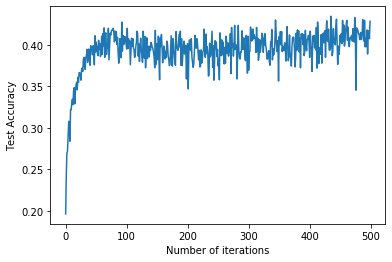

In [6]:
    plt.figure(1)
    plt.plot(range(epochs), test_acc)
    plt.ylabel('Test Accuracy')
    plt.xlabel('Number of iterations')
    plt.savefig('./A3a-Test_accuracy.png')

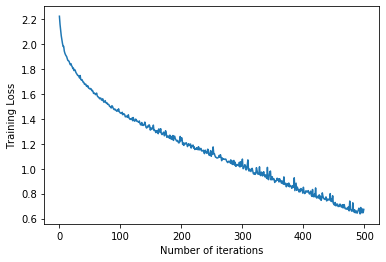

In [7]:
    plt.figure(2)
    plt.plot(range(epochs), training_loss)
    plt.xlabel('Number of iterations')
    plt.ylabel('Training Loss')
    plt.savefig('./A3a-Training_loss.png')